[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/01_preparacion_dataset_clasificacion_undersample.ipynb)

# Preparación del dataset de ninapro

## Autores

* Jairo Agudelo M.
* Henry Arcila.

## Descripción corta del dataset

El dataset a trabajar [db1_rms_features.csv](./datasets_tarea/db1_rms_features.csv) es el dataset resultante de la etapa previa de combinación de la base de datos en la etapa de preproceamiento ([link](00_preprocesamiento_dataset_clasificacion.ipynb)). Cada entrada de la base de datos contiene los valores RMS de cada uno de los 10 sensores EMG para una ventana de tiempo de 30 muestras de señal. A continuación se describen cada una de las columnas de la muestra.

Esta base de datos se describe a continuación:

| Columna               | Descripción                                       | Ejemplo   |
|:----------------------|:--------------------------------------------------|:----------|
| `s`                   | Sujeto                                            | 1         | 
| `emg1`                | Valor RMS sensor 1                                | 0.052510  | 
| `emg2`                | Valor RMS sensor 2                                | 0.002414  |	
| `emg3`                | Valor RMS sensor 3                                | 0.002445  |
| `emg4`                | Valor RMS sensor 4                                | 0.002417  |
| `emg5`                | Valor RMS sensor 5                                | 0.002400  |
| `emg6`                | Valor RMS sensor 6                                | 0.006204  |
| `emg7`                | Valor RMS sensor 7                                | 0.0024    |
| `emg8`                | Valor RMS sensor 8                                | 0.041218  |
| `emg9`                | Valor RMS sensor 9                                | 0.0024    |
| `emg1p`               | Valor RMS sensor 10                               | 0.019526  |
| `rep`                 | Repetición de la postura (1 - 10)                 | 4         |
| `label`               | Numero de la postura realizada  (1 - 12)          | 5         |

Los registros solo contienen la información de 10 sujetos.

## Objetivo a desarrollar

> * Realizar la preparación de los datos asociados a los valores rms de las señales emg de las ventanas de tiempo asociadas a cada una de las posturas.
> * Generar los dataset de entrenamiento y prueba.

## Resumen del proceso realizado

Se tomaron los datos del dataset y se llevaron a cabo las siguientes tareas:
* Se examino el dataframe.
* Se eliminaron las columnas que no eran relevantes para nuestro caso: Usuario (`s`) y repetición (`rep`).
* Se realizo una inspección visual de las variables de entrada numericas (`emg_x`) y la variable de salida correspondiente a la postura (`label`).
* Se dividio el dataframe en dos subdataframes, uno para entrenamiento y test (90%) y otro para pruebas (10%). 
* Como los datos estaban desbalanceados, ya que habian mas datos para la postura de descanso (0) que para las demas se realizo un submuestreo para balancear el dataframe que sera usado para el entrenamiento y test de los modelos.
* Se eliminaron datos atipicos del dataframe de entrenamieto y test usando `LocalOutlierFactor` empleando 26 vecinos.
* Se almacenaron los dataframes segun la siguiente tabla:

  |Dataframe|Archivo CSV|Descripción|
  |:---|:---|:---| 
  |`df`|[db1_rms_prep.csv](./datasets_tarea/db1_rms_prep.csv)|Datos de entrenamiento y test|
  |`dp`|[db1_rms_prue.csv](./datasets_tarea/db1_rms_prue.csv)|Datos de prueba para los modelos una vez se hayan entranado|.



Escogencia y uso de estrategias para manejar la información faltante en los datasets

## Desarrollo de experimentos

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
except ImportError:
    !pip install scipy

try:
    import imblearn
except ImportError:
    !pip install imblearn

In [2]:
# Determinacion si el archivo se va a ejecutar desde colab o local y configuracion de los elementos necesarios para la ejecucion
import sys
import os

# Path del notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    !git clone https://github.com/repos-especializacion-UdeA/trabajo-final_AA1.git
    %cd /content/trabajo-final_AA1/notebooks_pasos_previos   
    %pwd
    ruta_base = '/content/trabajo-final_AA1/notebooks_pasos_previos/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

## 2. Funciones

In [4]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones1 import multiple_plot

## 3. Carga del dataset

In [5]:
#Cargar el dataset
DATA_PATH = './datasets_tarea/'
d=pd.read_csv( DATA_PATH + 'db1_rms_features.csv')

In [6]:
d.shape

(46925, 13)

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46925 entries, 0 to 46924
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s       46925 non-null  int64  
 1   emg_1   46925 non-null  float64
 2   emg_2   46925 non-null  float64
 3   emg_3   46925 non-null  float64
 4   emg_4   46925 non-null  float64
 5   emg_5   46925 non-null  float64
 6   emg_6   46925 non-null  float64
 7   emg_7   46925 non-null  float64
 8   emg_8   46925 non-null  float64
 9   emg_9   46925 non-null  float64
 10  emg_10  46925 non-null  float64
 11  rep     46925 non-null  int64  
 12  label   46925 non-null  int64  
dtypes: float64(10), int64(3)
memory usage: 4.7 MB


In [ ]:
d.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.052510,0.002414,0.002445,0.002417,0.002400,0.006204,0.0024,0.041218,0.0024,0.019526,0,0
1,1,0.038543,0.002440,0.002513,0.002443,0.002426,0.002803,0.0024,0.029789,0.0024,0.005035,0,0
2,1,0.035662,0.002448,0.002564,0.002446,0.002478,0.001975,0.0024,0.025287,0.0024,0.000813,0,0
3,1,0.037038,0.002425,0.002542,0.002420,0.002526,0.002129,0.0024,0.026216,0.0024,0.001485,0,0
4,1,0.035718,0.002404,0.002478,0.002401,0.002542,0.002346,0.0024,0.026433,0.0024,0.002234,0,0


## 4. Limpieza de datos (Data Cleaning)

In [9]:
# Borrando columnas que no se emplearán
d.drop(['s'], axis='columns', inplace=True)
d.drop(['rep'], axis='columns', inplace=True)

In [10]:
# Convirtiendo la variable label a categorica
d['label'] = pd.Categorical(d['label'])

In [11]:
#Verificación y eliminación de registros duplicados

#Verificación de registros duplicados
d.loc[d.duplicated()]

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label


## 5. Visualización de datos

In [12]:
# Separacion del entradas y salidas

# Entrada
emg_data = d.iloc[:,:-1]
print(emg_data.shape)
# Salida
label_data = pd.DataFrame({'label': d.iloc[:,-1]})
print(label_data.shape)

(46925, 10)
(46925, 1)


In [13]:
emg_data.head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.052510,0.002414,0.002445,0.002417,0.002400,0.006204,0.0024,0.041218,0.0024,0.019526
1,0.038543,0.002440,0.002513,0.002443,0.002426,0.002803,0.0024,0.029789,0.0024,0.005035


In [ ]:
label_data.head(2)

,label
0,0
1,0


### Variables de entrada

In [15]:
numCols = emg_data.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
numCols

['emg_1',
 'emg_2',
 'emg_3',
 'emg_4',
 'emg_5',
 'emg_6',
 'emg_7',
 'emg_8',
 'emg_9',
 'emg_10']

In [16]:
emg_data[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.052510,0.002414,0.002445,0.002417,0.002400,0.006204,0.0024,0.041218,0.0024,0.019526
1,0.038543,0.002440,0.002513,0.002443,0.002426,0.002803,0.0024,0.029789,0.0024,0.005035


In [17]:
emg_data[numCols].describe()

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
count,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000,46925.000000
mean,0.071380,0.125086,0.095338,0.047645,0.013212,0.041203,0.268831,0.226359,0.135892,0.189476
std,0.215194,0.220086,0.254540,0.159635,0.034173,0.107138,0.443004,0.319496,0.297413,0.296369
min,0.000385,0.000306,0.000217,0.000316,0.000355,0.000350,0.000328,0.000326,0.000195,0.000296
25%,0.002941,0.002406,0.002542,0.002407,0.002492,0.002403,0.017919,0.049771,0.002424,0.004672
50%,0.005424,0.010434,0.004478,0.002469,0.002581,0.003538,0.137045,0.117343,0.011073,0.062891
75%,0.021904,0.169384,0.079824,0.014652,0.004082,0.029007,0.343469,0.283802,0.131968,0.253067
max,3.029289,2.953257,4.457169,4.642773,0.852200,1.890914,4.768665,4.355482,4.015512,2.897257


In [18]:
#Lista de variables categóricas
catCols = emg_data.select_dtypes(include = ['object', 'category']).columns.tolist()
catCols

[]

In [19]:
#Lista de variables numéricas

emg_data[catCols].head(2)

""
0
1


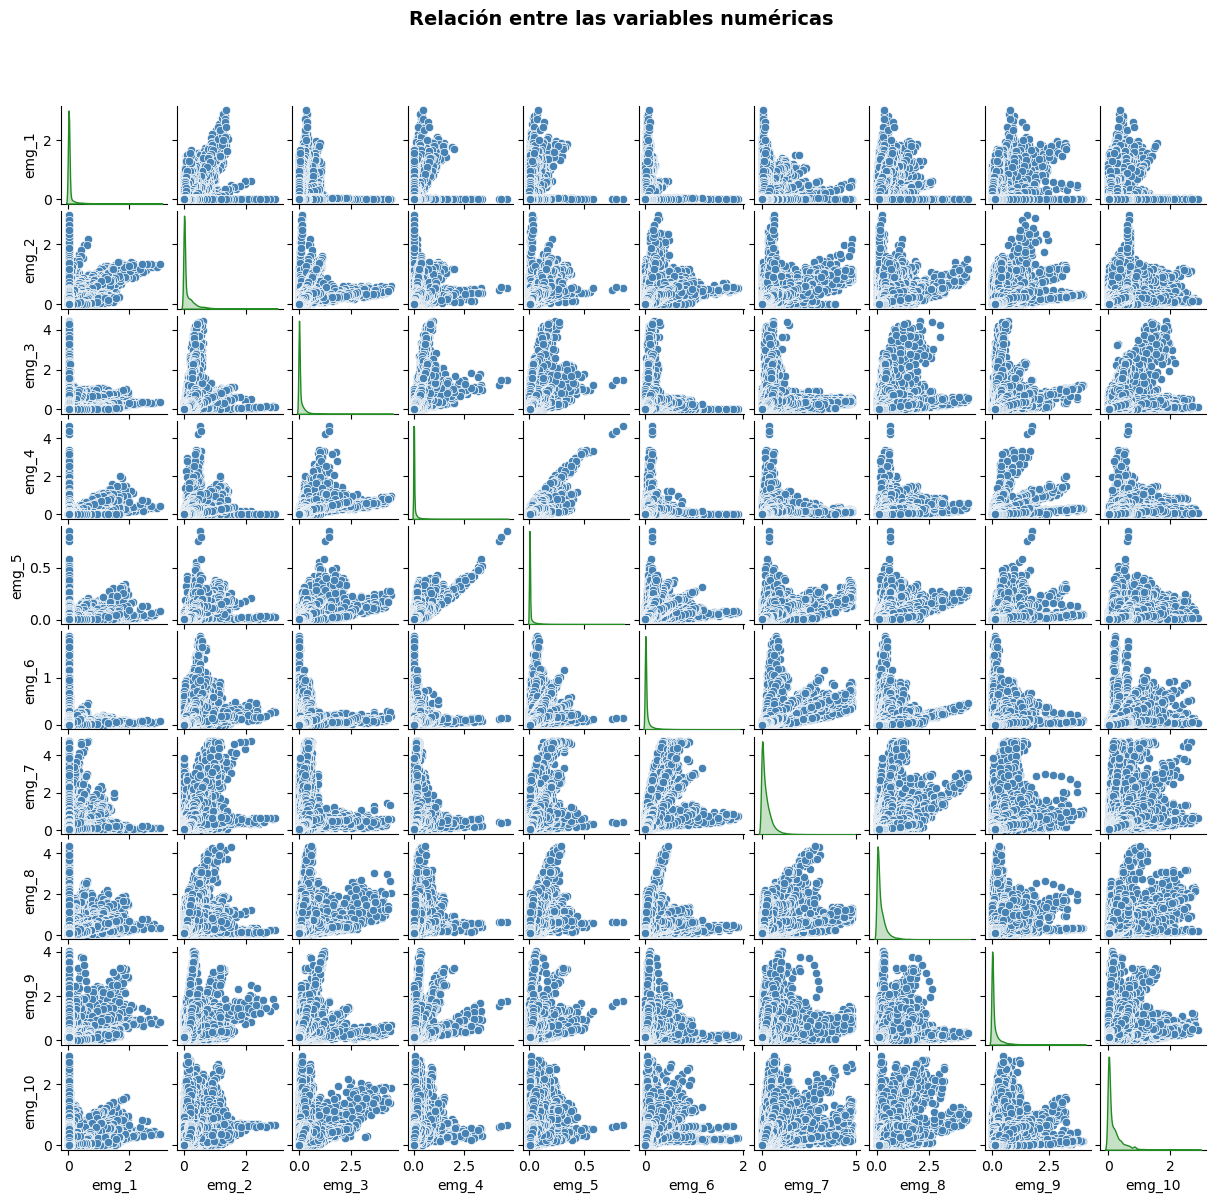

In [20]:
#Visualización de variables numéricas
multiple_plot(1, emg_data , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

### Variable de salida

In [21]:
# Distribución de cada variable categórica en el conjunto de datos

for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(d[col].value_counts())
    print()

In [22]:
d.groupby('label').label.count().sort_values(ascending=False)

label
0     26853
3      1876
8      1776
1      1747
5      1703
7      1697
12     1686
10     1684
6      1652
2      1629
4      1556
11     1546
9      1520
Name: label, dtype: int64

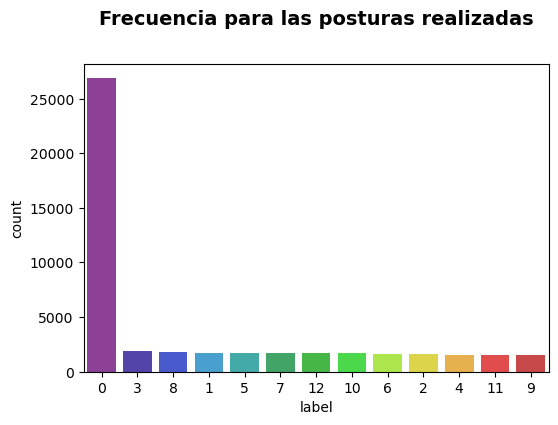

In [23]:
multiple_plot(1, label_data , None, 'label', 'countplot', 'Frecuencia para las posturas realizadas',0)

## 6. Preparación de datos

### Imputaciones

No se requiere imputaciones, solo se realizará la verificación de la completitud

In [24]:
# Identificación de valores nulos para las variables numéricas
for col in d[numCols]:
    print (col, np.sum(pd.isnull(d[col])))

emg_1 0
emg_2 0
emg_3 0
emg_4 0
emg_5 0
emg_6 0
emg_7 0
emg_8 0
emg_9 0
emg_10 0


In [25]:
# Identificación de valores nulos para las variables categóricas
for col in d[catCols]:
    print (col, np.sum(pd.isnull(d[col])))

### Transformaciones

Por ahora no se van a realizar transformaciones

In [26]:
# To Do

### Datos de prueba

In [27]:
# Porcentaje de filas para la primera parte (por ejemplo, 90%)
percentage_first_part = 0.90

# Número de filas para la primera parte
n_rows_part1 = int(len(d) * percentage_first_part)

# Obtener índices aleatorios para la primer parte
indices_part1 = d.sample(n=n_rows_part1, random_state=123).index

# Obtener índices para la segunda parte (resto de las filas)
indices_part2 = d.index.difference(indices_part1)

# Dividir el DataFrame en dos partes
df = d.loc[indices_part1]
dp = d.loc[indices_part2]

In [28]:
print(df.shape)
print(dp.shape)
print("------------")
print(d.shape)

(42232, 11)
(4693, 11)
------------
(46925, 11)


### Valores atípicos para las variables de entrada

In [29]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada

vecinos = 26
# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors = vecinos, contamination=0.1)

# identificar los valores atípicos por medio de lof 
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [40203, 9618, 34242, 1399, 32025, 23419, 41491, 10026, 23418, 26998, 10972, 34724, 11064, 42245, 32944, 34275, 26891, 2834, 34124, 10954, 13819, 7261, 1642, 23876, 40059, 8877, 43134, 29624, 10101, 45213, 13765, 41405, 10706, 45617, 9407, 38358, 41146, 28159, 45222, 5461, 43054, 2732, 694, 17088, 10364, 30556, 21666, 8485, 3762, 23228, 26518, 595, 17408, 16799, 13703, 279, 20195, 46598, 36014, 2419, 1795, 5467, 37593, 3852, 43912, 33077, 35527, 15491, 32018, 15535, 36455, 3152, 35097, 2689, 36640, 19536, 12887, 38691, 34376, 4221, 4355, 31244, 15141, 1325, 28163, 26892, 24966, 18701, 704, 41855, 21135, 5462, 35324, 16374, 26514, 37681, 23415, 34316, 41002, 36259, 8483, 37000, 46536, 1722, 19457, 37301, 18280, 6009, 14038, 44326, 39757, 40084, 18351, 34083, 39348, 23738, 3146, 10179, 38969, 27174, 2423, 719, 332, 12775, 15258, 40122, 13439, 29625, 40287, 3616, 14745, 25656, 9585, 5361, 5862, 35991, 3416, 27904, 1058, 13639, 2824, 43411, 13766, 8998, 31705, 

In [30]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

In [31]:
df.shape

(38008, 11)

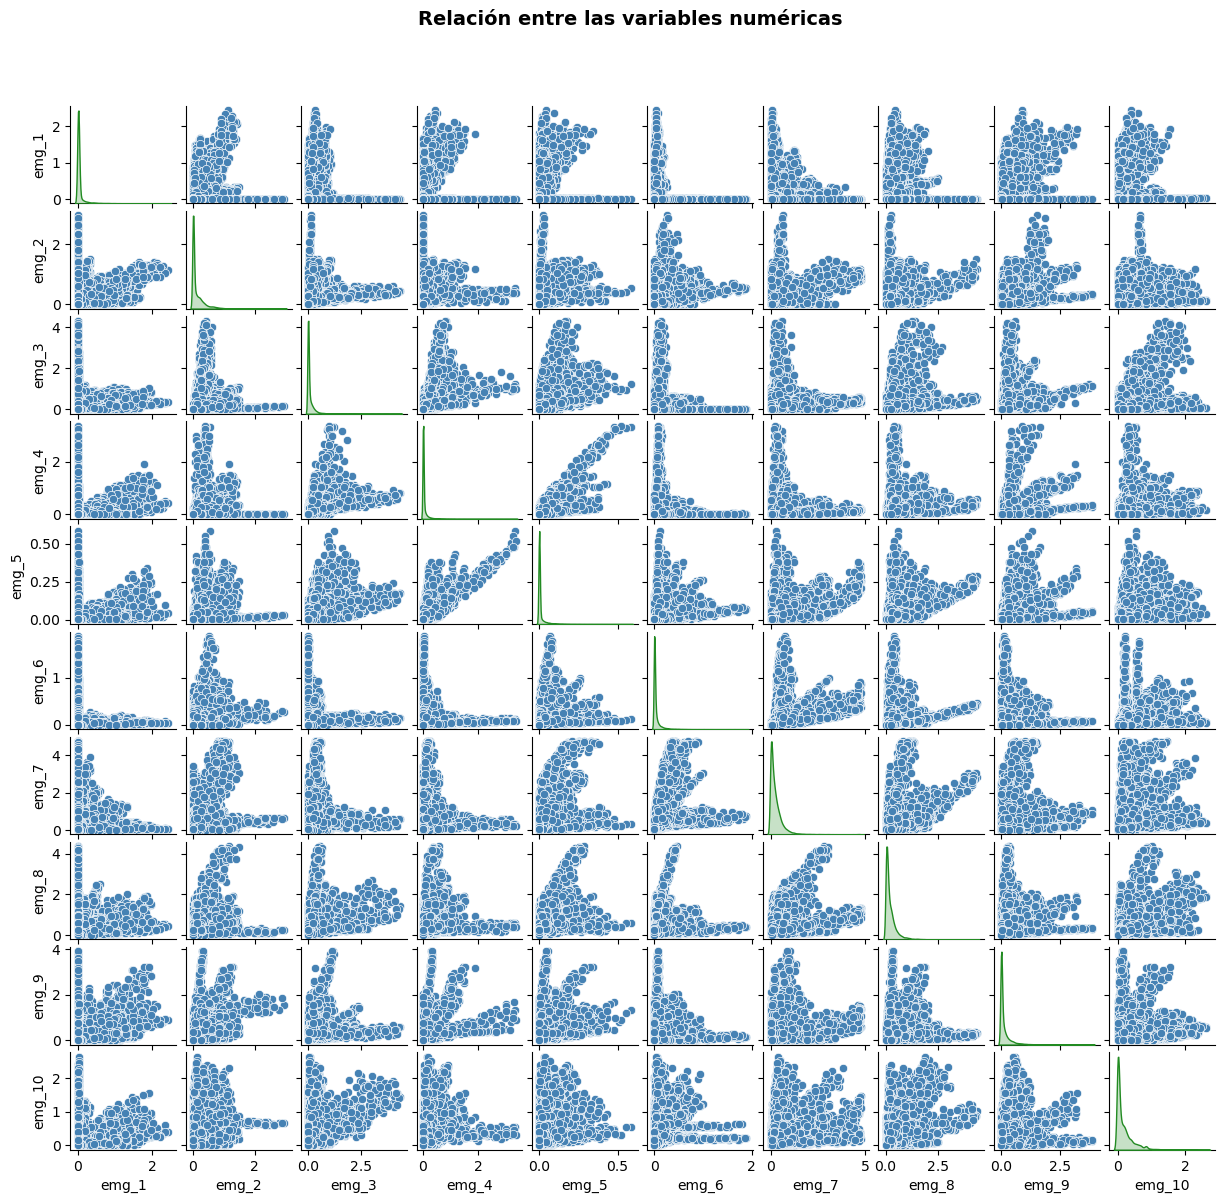

In [32]:
#Visualización de variables numéricas
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

### Submuestreo (undersampling)

In [33]:
#!pip install imblearn

In [60]:
df.columns

Index(['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8',
       'emg_9', 'emg_10', 'label'],
      dtype='object')

In [35]:
# Se crea un objeto RandomUnderSampler que permite crear copias aleatorias de las muestras de la clase 

rus = RandomUnderSampler()

# Se realiza el sobremuestreo para las variables de entrada y salida

# Aplicar undersampling
X_resampled, y_resampled = rus.fit_resample(df[numCols], df['label'])

# Se crean dos dataframes con las variables de entrada y otro con la variable de salida a partir del proceso anterior
df1 = pd.DataFrame(X_resampled, columns=df[numCols].columns)
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
df_balanced = pd.concat([df1, df2], axis=1)

# df=df_balanced

In [36]:
print(df.shape)             # Caso desbalanceado
print(df_balanced.shape)    # Caso balanceado

(38008, 11)
(16250, 11)


In [37]:
# Actualizando el dataframe de trabajo para que quede con el caso balanceado
df = df_balanced
df.shape

(16250, 11)

In [38]:
# Dataset balanceado
df.head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
6300,0.516068,0.580968,0.173756,0.068346,0.031557,0.002400,0.002447,0.049063,0.608643,0.006596,0
8751,0.123792,0.290991,0.007430,0.002466,0.002441,0.002399,0.002422,0.008951,0.002594,0.002414,0


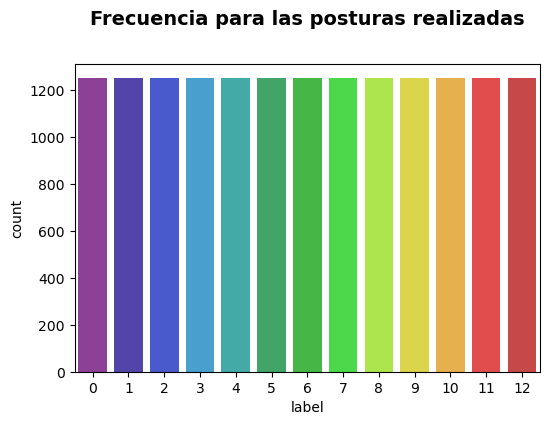

In [39]:
multiple_plot(1, df_balanced , None, 'label', 'countplot', 'Frecuencia para las posturas realizadas',0)

## 7. Exportar el dataset

In [40]:
# Exportamos el dataframe a un archivo CSV
df.to_csv('./datasets_tarea/db1_rms_prep.csv', index=False)
dp.to_csv('./datasets_tarea/db1_rms_prue.csv', index=False)

## Conclusiones

* Los datos empleados no requirieron mayores procesos de preparación salvo la eliminación de outliers.
* Como los datos estaban desbalanceados se opto por realizar un submuestreo.
* El resultado final fueron dos archivos csv con los datos que seran empleados para en entrenamiento y prueba de los modelos.

### Referencias


- *Dataset:*  
    - https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=car+details+v4.csv
    
    
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    
    
- *LocalOutlierFactor:*
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180

  